In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, adjusted_rand_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Set plot style
sns.set(style='whitegrid')

## 1. Load and Inspect the dataset

In [2]:
# Load dataset
data = pd.read_csv("teen_phone_addiction_dataset.csv")

# View shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (3000, 25)


,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,1.4,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,0.9,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,0.5,137,8,0.3,1.5,0.4,Education,6,5.7,9.2
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,1.4,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,1.0,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6


## 2.1 Data cleaning 

In [3]:
# Drop rows with missing values
data.dropna(inplace=True)


# Convert Addiction_Level into binary classification
# Addiction scores > 7.0 are labeled as 'High' (1), otherwise 'Low' (0)

data["Addiction_Binary"] = data["Addiction_Level"].apply(lambda x: 1 if x > 7.0 else 0)
data.head()

,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level,Addiction_Binary
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0,1
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0,1
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,137,8,0.3,1.5,0.4,Education,6,5.7,9.2,1
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8,1
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6,1


## 2.2. Descriptive Statistics

In [4]:
# Summary of numerical features
data.describe()

,ID,Age,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,Exercise_Hours,Anxiety_Level,Depression_Level,Self_Esteem,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Family_Communication,Weekend_Usage_Hours,Addiction_Level,Addiction_Binary
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,15.969667,5.020667,6.489767,74.947333,5.097667,1.040667,5.590000,5.460333,5.546333,...,1.006733,83.093000,12.609333,2.499233,1.525267,1.016333,5.459667,6.015100,8.881900,0.851333
std,866.169729,1.989489,1.956501,1.490713,14.684156,3.139333,0.734620,2.890678,2.871557,2.860754,...,0.492878,37.747044,4.611486,0.988201,0.932701,0.648341,2.864572,2.014776,1.609598,0.355819
min,1.000000,13.000000,0.000000,3.000000,50.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,20.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,750.750000,14.000000,3.700000,5.500000,62.000000,2.000000,0.500000,3.000000,3.000000,3.000000,...,0.700000,51.000000,9.000000,1.800000,0.800000,0.500000,3.000000,4.700000,8.000000,1.000000
50%,1500.500000,16.000000,5.000000,6.500000,75.000000,5.000000,1.000000,6.000000,5.000000,6.000000,...,1.000000,82.000000,13.000000,2.500000,1.500000,1.000000,5.000000,6.000000,10.000000,1.000000
75%,2250.250000,18.000000,6.400000,7.500000,88.000000,8.000000,1.500000,8.000000,8.000000,8.000000,...,1.400000,115.250000,17.000000,3.200000,2.200000,1.500000,8.000000,7.400000,10.000000,1.000000
max,3000.000000,19.000000,11.500000,10.000000,100.000000,10.000000,4.000000,10.000000,10.000000,10.000000,...,2.600000,150.000000,20.000000,5.000000,4.000000,3.000000,10.000000,14.000000,10.000000,1.000000


In [5]:
# Check data types
data.dtypes

ID                          int64
Name                       object
Age                         int64
Gender                     object
Location                   object
School_Grade               object
Daily_Usage_Hours         float64
Sleep_Hours               float64
Academic_Performance        int64
Social_Interactions         int64
Exercise_Hours            float64
Anxiety_Level               int64
Depression_Level            int64
Self_Esteem                 int64
Parental_Control            int64
Screen_Time_Before_Bed    float64
Phone_Checks_Per_Day        int64
Apps_Used_Daily             int64
Time_on_Social_Media      float64
Time_on_Gaming            float64
Time_on_Education         float64
Phone_Usage_Purpose        object
Family_Communication        int64
Weekend_Usage_Hours       float64
Addiction_Level           float64
Addiction_Binary            int64
dtype: object

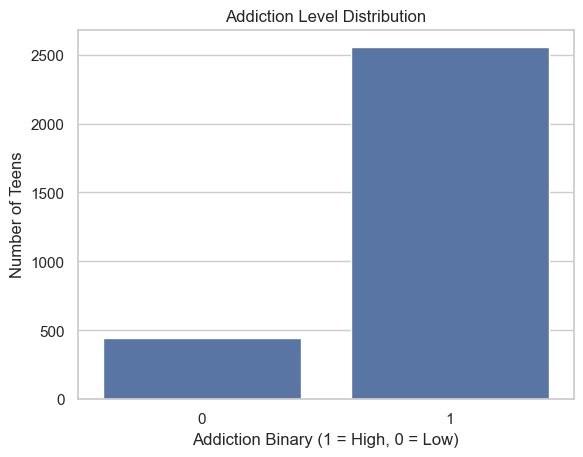

Addiction_Binary
1    2554
0     446
Name: count, dtype: int64


In [6]:
# Check distribution of the target variable
sns.countplot(x="Addiction_Binary", data=data)
plt.title("Addiction Level Distribution")
plt.xlabel("Addiction Binary (1 = High, 0 = Low)")
plt.ylabel("Number of Teens")
plt.show()

# Display value counts
print(data["Addiction_Binary"].value_counts())

## 2.3 Univariate Visualizations

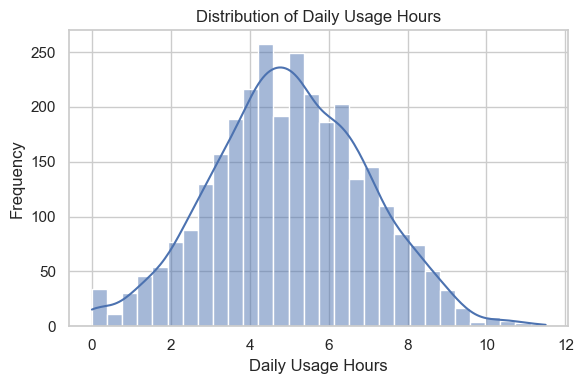

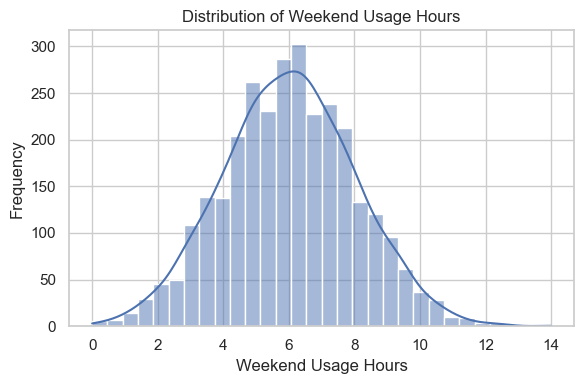

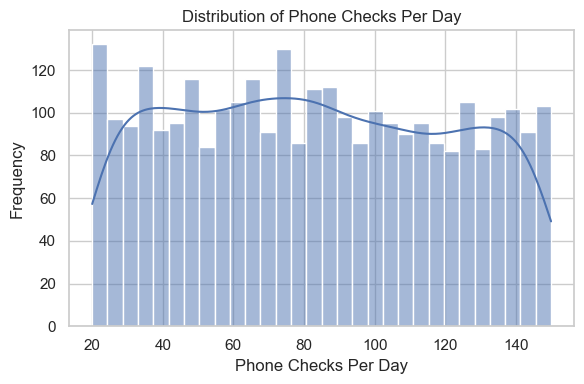

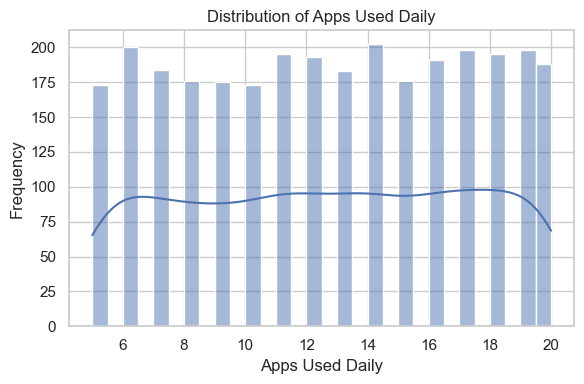

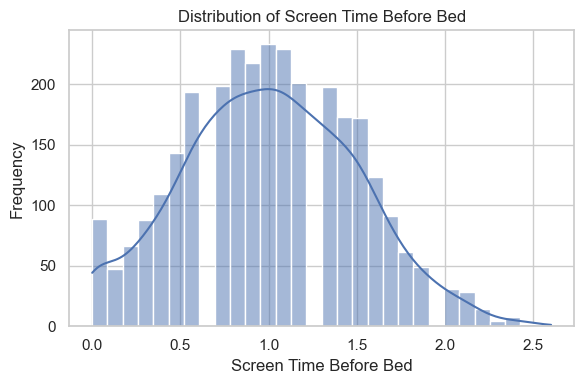

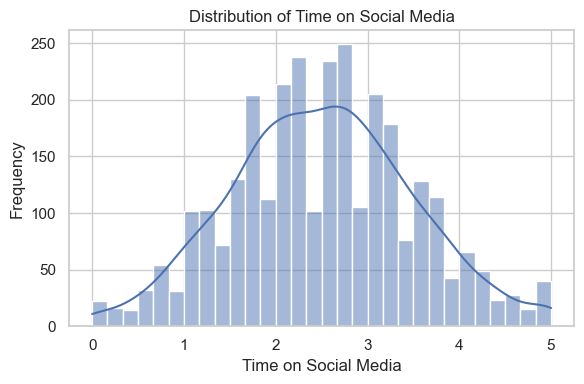

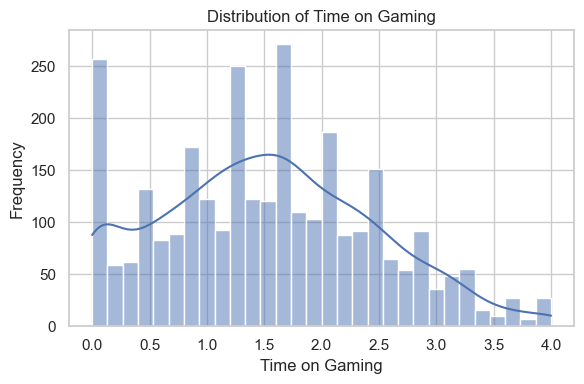

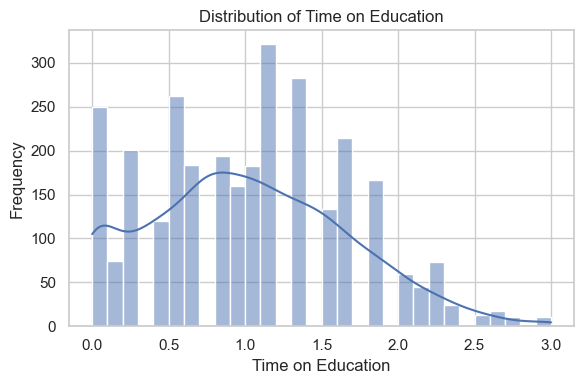

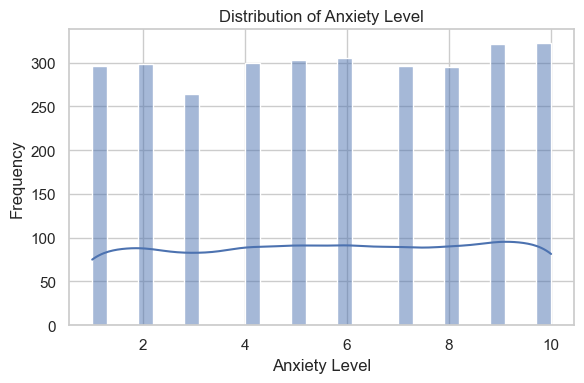

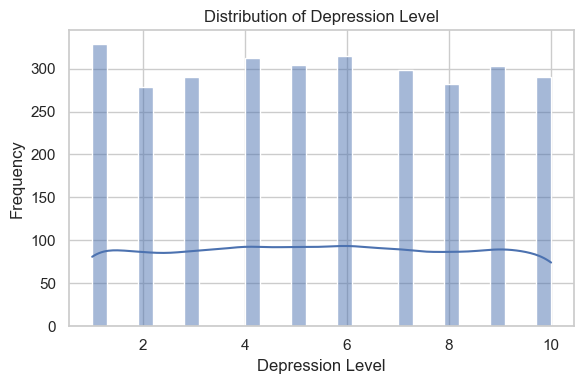

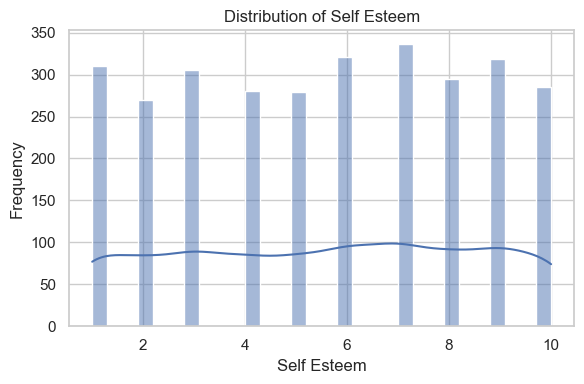

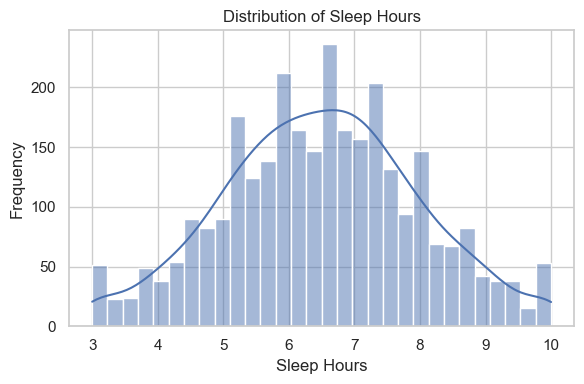

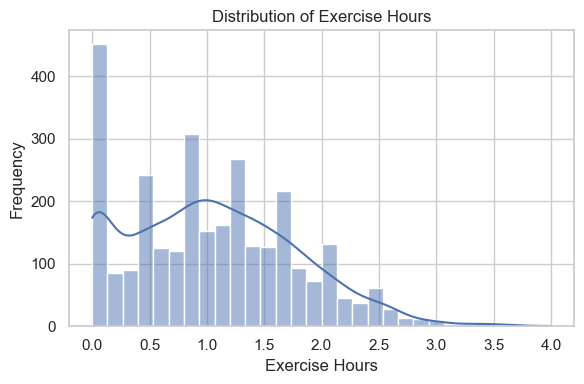

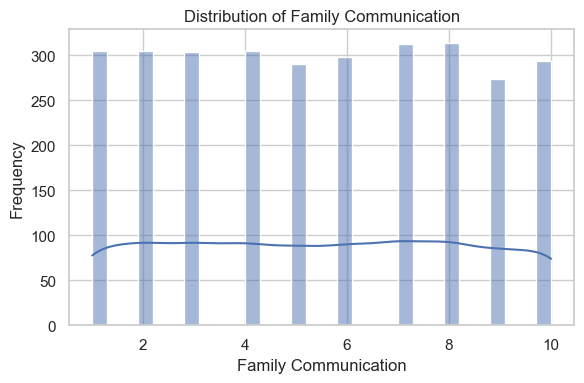

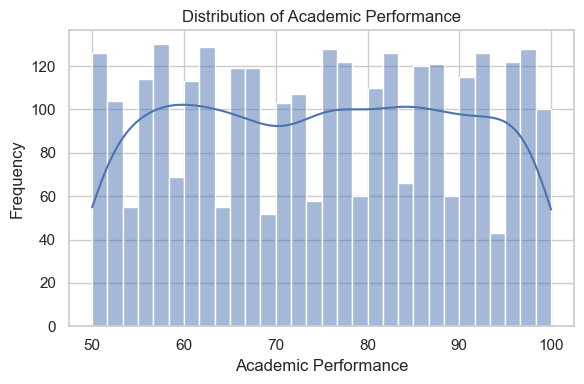

In [7]:
# List of features to plot
usage_features = [
    "Daily_Usage_Hours", "Weekend_Usage_Hours", "Phone_Checks_Per_Day",
    "Apps_Used_Daily", "Screen_Time_Before_Bed", "Time_on_Social_Media",
    "Time_on_Gaming", "Time_on_Education"
]

mental_health_features = ["Anxiety_Level", "Depression_Level", "Self_Esteem"]
lifestyle_features = ["Sleep_Hours", "Exercise_Hours", "Family_Communication"]
academic_feature = ["Academic_Performance"]

# Plot numeric feature distributions
all_features = usage_features + mental_health_features + lifestyle_features + academic_feature

for col in all_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f"Distribution of {col.replace('_', ' ')}")
    plt.xlabel(col.replace('_', ' '))
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()



## 2.4 Bivariate Analysis & Statistical Testing

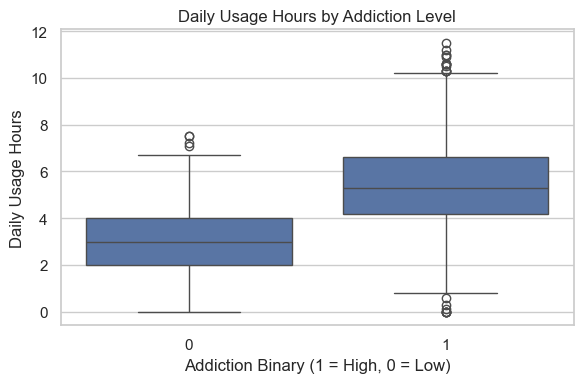

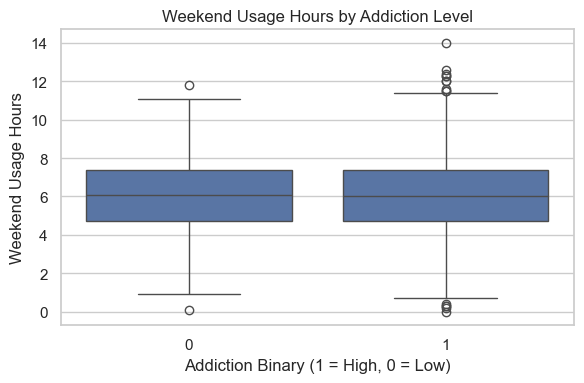

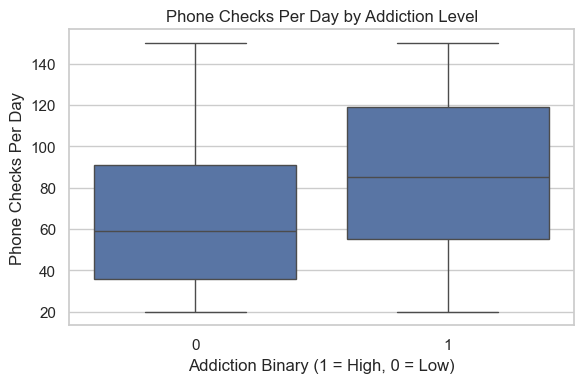

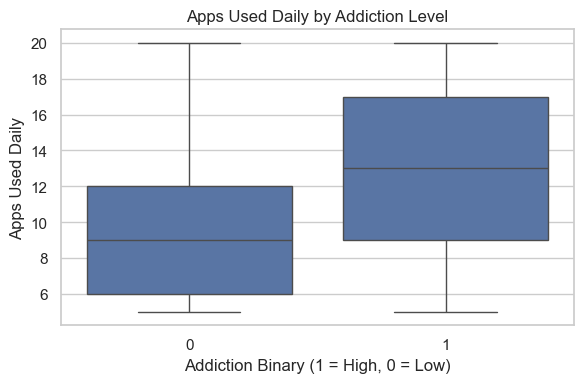

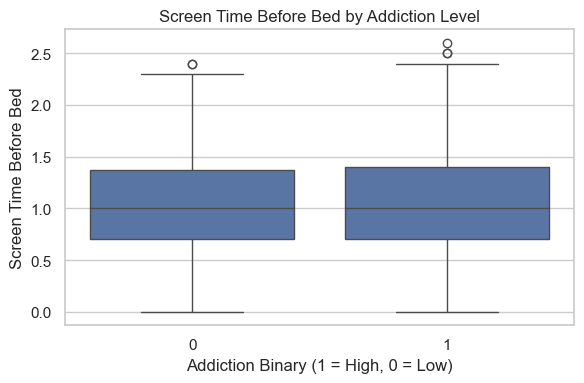

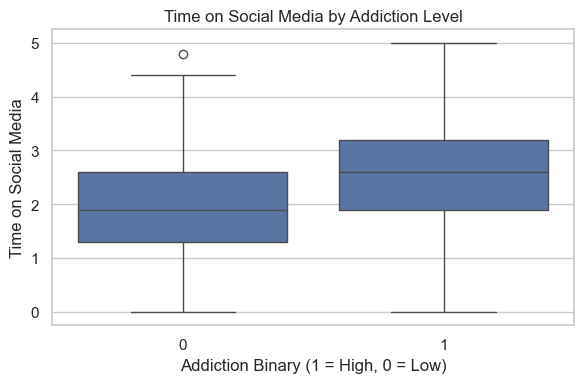

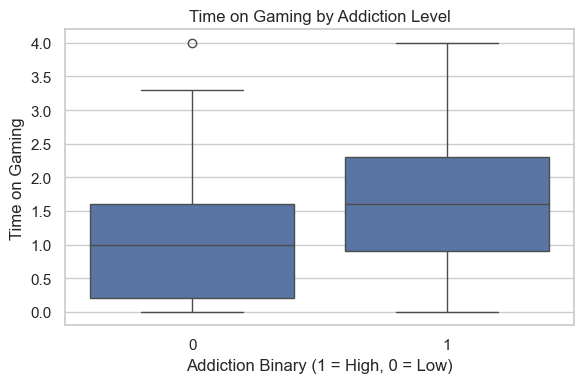

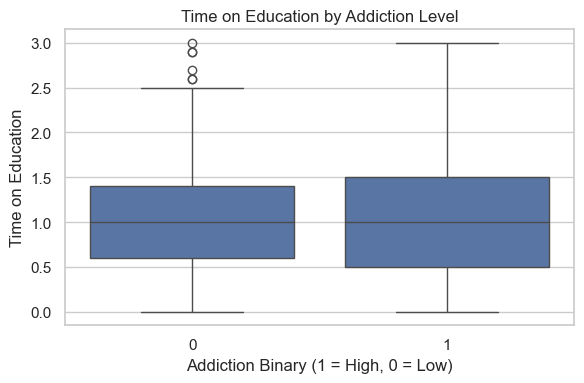

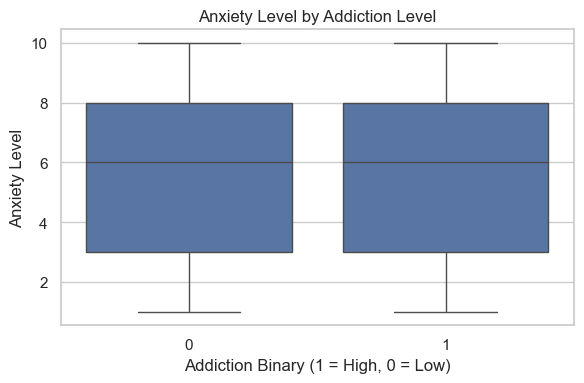

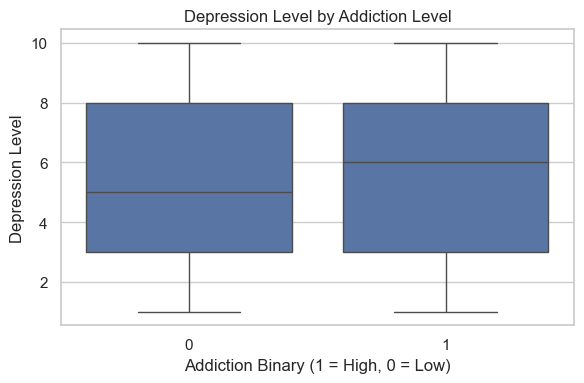

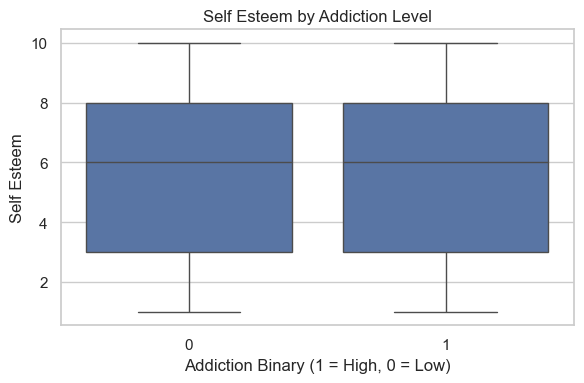

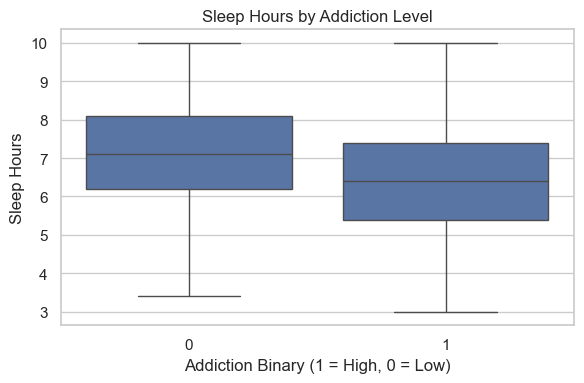

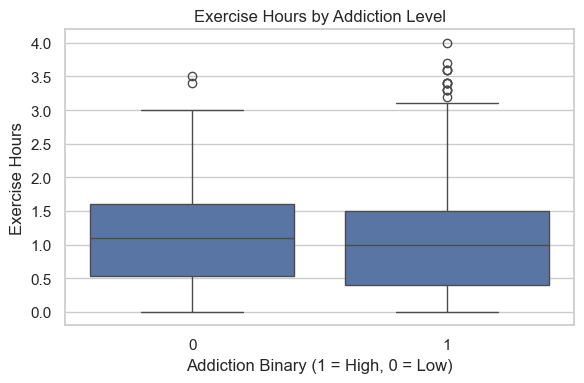

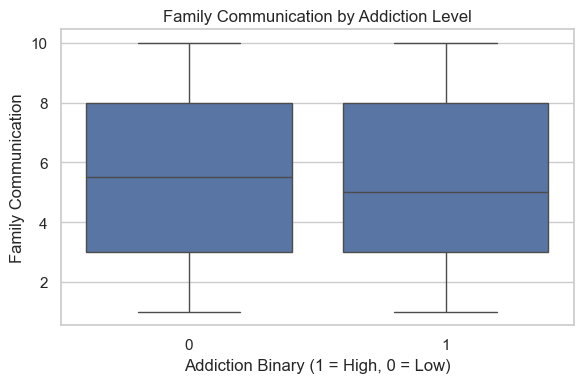

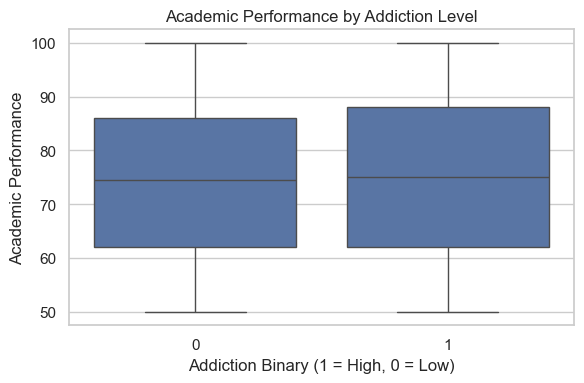

In [8]:
# Box plot by addiction Binary

for col in all_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="Addiction_Binary", y=col, data=data)
    plt.title(f"{col.replace('_', ' ')} by Addiction Level")
    plt.xlabel("Addiction Binary (1 = High, 0 = Low)")
    plt.ylabel(col.replace('_', ' '))
    plt.tight_layout()
    plt.show()


In [10]:
# T-Tests

# Split data by addiction level
high = data[data["Addiction_Binary"] == 1]
low = data[data["Addiction_Binary"] == 0]

# Run t-tests
from scipy.stats import ttest_ind

print("T-test Results:\n")
for col in all_features:
    t_stat, p_val = ttest_ind(high[col], low[col])
    print(f"{col}: t-stat = {t_stat:.3f}, p-value = {p_val:.5f}")

T-test Results:

Daily_Usage_Hours: t-stat = 26.349, p-value = 0.00000
Weekend_Usage_Hours: t-stat = -0.542, p-value = 0.58813
Phone_Checks_Per_Day: t-stat = 10.493, p-value = 0.00000
Apps_Used_Daily: t-stat = 14.144, p-value = 0.00000
Screen_Time_Before_Bed: t-stat = -0.083, p-value = 0.93389
Time_on_Social_Media: t-stat = 13.105, p-value = 0.00000
Time_on_Gaming: t-stat = 12.438, p-value = 0.00000
Time_on_Education: t-stat = -0.278, p-value = 0.78087
Anxiety_Level: t-stat = 0.961, p-value = 0.33655
Depression_Level: t-stat = 1.167, p-value = 0.24320
Self_Esteem: t-stat = -1.423, p-value = 0.15471
Sleep_Hours: t-stat = -10.017, p-value = 0.00000
Exercise_Hours: t-stat = -1.751, p-value = 0.07997
Family_Communication: t-stat = 0.072, p-value = 0.94272
Academic_Performance: t-stat = 0.606, p-value = 0.54434


###  2.5 Correlation Matrix

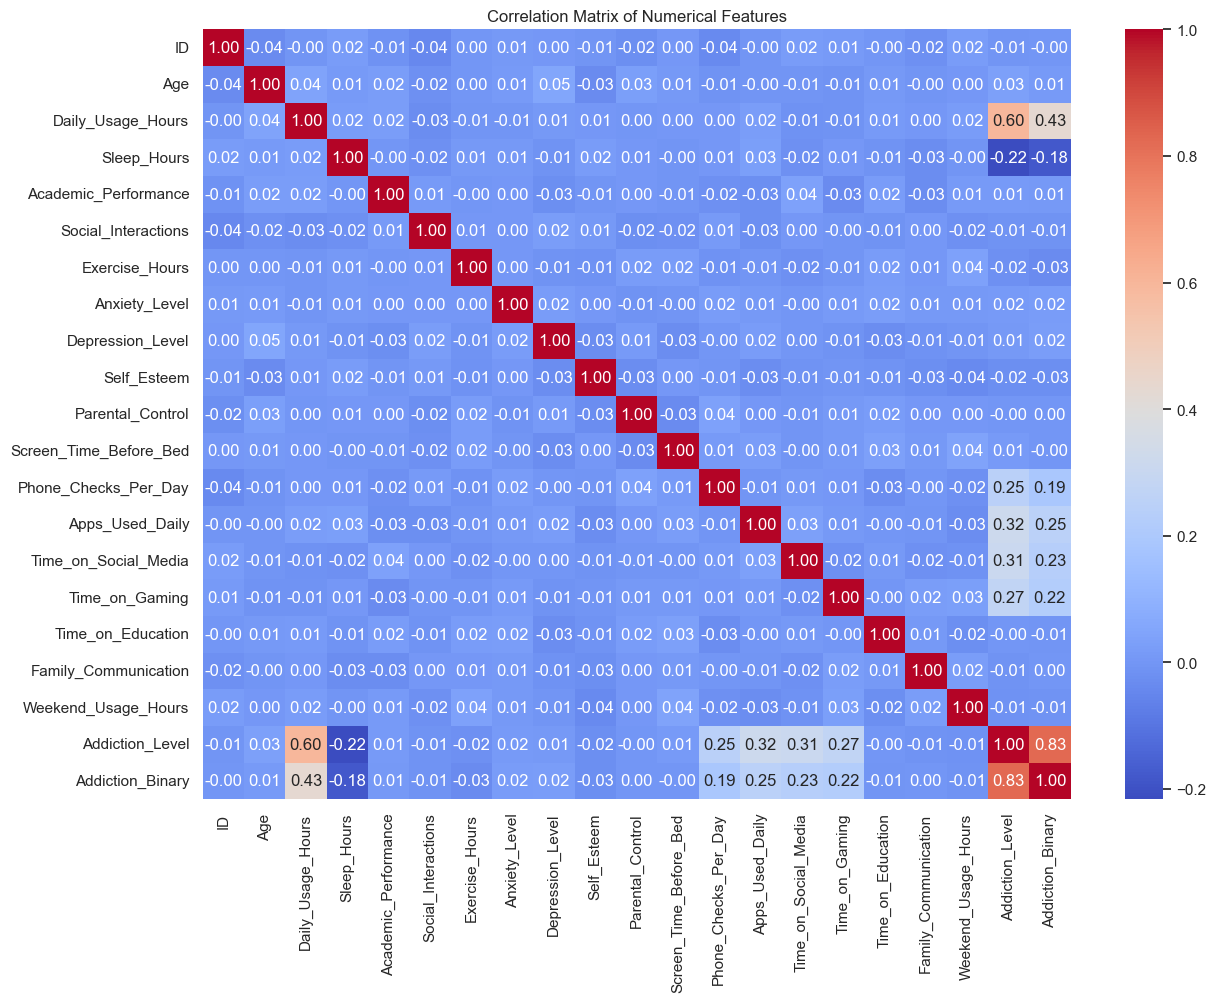

In [11]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [12]:
# Print correlation with target variable only
correlations = data.corr(numeric_only=True)["Addiction_Binary"].sort_values(ascending=False)
print("Correlation with Addiction_Binary:\n", correlations)


Correlation with Addiction_Binary:
 Addiction_Binary          1.000000
Addiction_Level           0.827273
Daily_Usage_Hours         0.433626
Apps_Used_Daily           0.250108
Time_on_Social_Media      0.232770
Time_on_Gaming            0.221513
Phone_Checks_Per_Day      0.188220
Depression_Level          0.021313
Anxiety_Level             0.017551
Age                       0.013411
Academic_Performance      0.011073
Family_Communication      0.001312
Parental_Control          0.000507
Screen_Time_Before_Bed   -0.001515
ID                       -0.002694
Time_on_Education        -0.005081
Weekend_Usage_Hours      -0.009891
Social_Interactions      -0.009982
Self_Esteem              -0.025988
Exercise_Hours           -0.031971
Sleep_Hours              -0.179956
Name: Addiction_Binary, dtype: float64


In [13]:
# Model Prep:
X = pd.get_dummies(data.drop(["ID", "Name", "Addiction_Level", "Addiction_Binary"], axis=1), drop_first=True)
y = data["Addiction_Binary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(y_train_balanced.value_counts())

# Here we start with converting categorical variables to 1's and 0's and storing them in x as features. This is one 
# hot encoding, which allows models to better understand the data. The ID and name column are dropped as they provide 
# no predictive power. Addiction level is removed since we are using low and high categories instead of the number 
# ratings 1-10. Addiction binary is removed as this is the target variable that we need to store in y not in x where 
# the features are. Drop first is set to true to avoid dummy variable trap. Then the data is split into train and test 
# sets, 80% training, 20% testing. Stratify Y esnsures the split maintains the same proportion of high and low 
# addiction levels in both sets. Random state = 42 is for reproducibility. Then SMOTE is applied to balance the training 
# dataset. We then print the value counts of each addiction level to be sure they are the same.

Addiction_Binary
1    2043
0    2043
Name: count, dtype: int64


## Logistic Regression Model

In [14]:
# Logistic Regression Model
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_balanced, y_train_balanced)
predictions_log_reg = log_reg.predict(X_test)

print("Logistic Regression Summary: \n")
print(classification_report(y_test, predictions_log_reg))
print("Adjusted Rand Index: ", round(adjusted_rand_score(y_test, predictions_log_reg), 4))

# Here we initialize the logistic regression model and set max iterations to 2000 to allow more iterations to converge
# in training. This helps with large datasets. Then model training is done using the SMOTE balanced training data. Then the 
# model is used to predict the addiction risk on the unseen test dataset. Then the classification report of the model is 
# outputted. Then the ARI is calculated and outputted. 

Logistic Regression Summary: 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        89
           1       0.99      0.99      0.99       511

    accuracy                           0.98       600
   macro avg       0.96      0.98      0.97       600
weighted avg       0.98      0.98      0.98       600

Adjusted Rand Index:  0.9142


True Negatives: 86
False Positives: 3
False Negatives: 7
True Positives: 504


<Figure size 600x500 with 0 Axes>

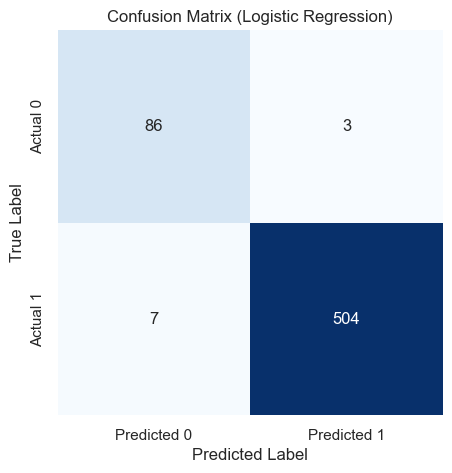

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix based on true labels and model predictions.
cm = confusion_matrix(y_test, predictions_log_reg)
tn, fp, fn, tp = cm.ravel()

# Print each of the confusion matrix components to understand model performance
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Define labels for axes and annotations (not directly used in heatmap here)
group_names = [["True Neg", "False Pos"],
               ["False Neg", "True Pos"]]

# Set up the plot figure with specified size (width=6 inches, height=5 inches)
plt.figure(figsize=(6, 5))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"], cbar=False, square=True)

# Add a title for the heatmap plot
plt.title("Confusion Matrix (Logistic Regression)")

# Label the x-axis as predicted class labels
plt.xlabel("Predicted Label")

# Label the y-axis as true class labels
plt.ylabel("True Label")

# Display the plot
plt.show()

In [17]:
# Gradient Boosting Model
gboost = GradientBoostingClassifier(random_state=42)
gboost.fit(X_train_balanced, y_train_balanced)
predictions_gboost = gboost.predict(X_test)

print("Gradient Boosting Summary: \n")
print(classification_report(y_test, predictions_gboost))
print("Adjusted Rand Index: ", round(adjusted_rand_score(y_test, predictions_gboost), 4))

# Here we initialize the gradient boosting model. The random state is 42 for reproducibility. Then model training is 
# done using the SMOTE balanced training data. Then the model is used to predict the addiction risk on the unseen test 
# dataset. Then the classification report of the model is outputted. Then the ARI is calculated and outputted. 

Gradient Boosting Summary: 

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        89
           1       0.98      0.97      0.98       511

    accuracy                           0.96       600
   macro avg       0.92      0.94      0.93       600
weighted avg       0.96      0.96      0.96       600

Adjusted Rand Index:  0.8076


True Negatives (TN): 80
False Positives (FP): 9
False Negatives (FN): 14
True Positives (TP): 497


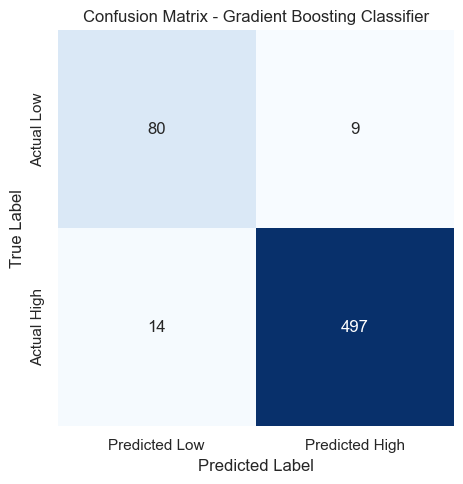

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions_gboost)
tn, fp, fn, tp = cm.ravel()

# Print values
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'],
            square=True, cbar=False)

plt.title("Confusion Matrix - Gradient Boosting Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [19]:
# Random Forest Optimized Model

rf = RandomForestClassifier(random_state=42)
parameters = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
rf_optimized = RandomizedSearchCV(rf, parameters, n_iter=5, cv=3, random_state=42)
rf_optimized.fit(X_train_balanced, y_train_balanced)
predictions_rf = rf_optimized.predict(X_test)

print("Random Forest Summary: \n")
print(classification_report(y_test, predictions_rf))
print("Adjusted Rand Index: ", round(adjusted_rand_score(y_test, predictions_rf), 4))

# Here we initialize the random forest model. The random state is 42 for reproducibility. Then the parameters are set for optimization.
# The n_estimators allows us to run deifferent size trees to find the optimal one, large tree can reduce variance. Max_depth allows 
# us to control the depth of each tree, shallow trees can help avoid overfitting. We then use randomized search to get best hyperparameters.
# Here we feed the model, previous parameters for tree size/depth, n_iter = 5 means 5 random combos are tried, cv = 3 performs 3 fold 
# cross validation for each combo and random_state = 42 is for reproducibility purposes. Then model training is 
# done using the SMOTE balanced training data. Then the model is used to predict the addiction risk on the unseen test 
# dataset. Then the classification report of the model is outputted. Then the ARI is calculated and outputted. 

Random Forest Summary: 

              precision    recall  f1-score   support

           0       0.64      0.38      0.48        89
           1       0.90      0.96      0.93       511

    accuracy                           0.88       600
   macro avg       0.77      0.67      0.70       600
weighted avg       0.86      0.88      0.86       600

Adjusted Rand Index:  0.3491



Confusion Matrix Values:
True Negatives (TN): 34
False Positives (FP): 55
False Negatives (FN): 19
True Positives (TP): 492


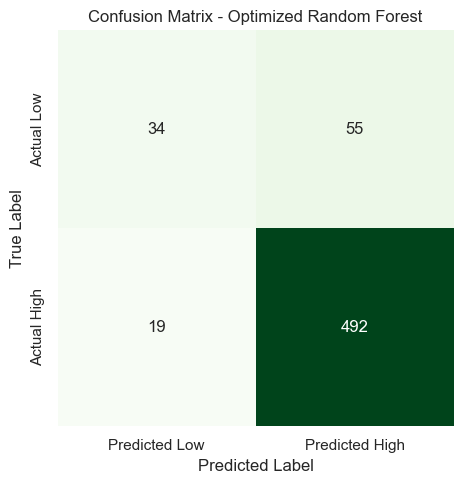

In [20]:
# Generate and print confusion matrix values
cm = confusion_matrix(y_test, predictions_rf)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix Values:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'],
            square=True, cbar=False)

plt.title("Confusion Matrix - Optimized Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## XGBoost Optimized Model

In [23]:
# XGBoost Optimized Model

xgboost = XGBClassifier(eval_metric='logloss', random_state=42)
parameters_xgb = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 8], 'learning_rate': [0.05, 0.1, 0.2]}
xgb_optimized = RandomizedSearchCV(xgboost, parameters_xgb, n_iter=5, cv=3, random_state=42)
xgb_optimized.fit(X_train_balanced, y_train_balanced)
predictions_xgb = xgb_optimized.predict(X_test)

print("XGBoost Summary: \n")
print(classification_report(y_test, predictions_xgb))
print("Adjusted Rand Index: ", round(adjusted_rand_score(y_test, predictions_xgb), 4))

# Here we initialize the xgboost model. The eval_metric is logloss because this is a case of binary classification, 
# random state is 42 for reproducibility. Then the parameters are set for optimization.
# The n_estimators allows us to run different number of tree sizes, more means better accuracy usually. Max_depth allows 
# us to control the depth of each tree, shallow trees can help avoid overfitting. Learning_rate controls how much each new tree 
# affects the model, a smaller step size usually results in better accuracy. We then use randomized search to get best hyperparameters.
# Here we feed the model, previous parameters above, n_iter = 5 means 5 random combos are tried, cv = 3 performs 3 fold 
# cross validation for each combo and random_state = 42 is for reproducibility purposes. Then model training is 
# done using the SMOTE balanced training data. Then the model is used to predict the addiction risk on the unseen test 
# dataset. Then the classification report of the model is outputted. Then the ARI is calculated and outputted. 

XGBoost Summary: 

              precision    recall  f1-score   support

           0       0.87      0.84      0.86        89
           1       0.97      0.98      0.98       511

    accuracy                           0.96       600
   macro avg       0.92      0.91      0.92       600
weighted avg       0.96      0.96      0.96       600

Adjusted Rand Index:  0.7864


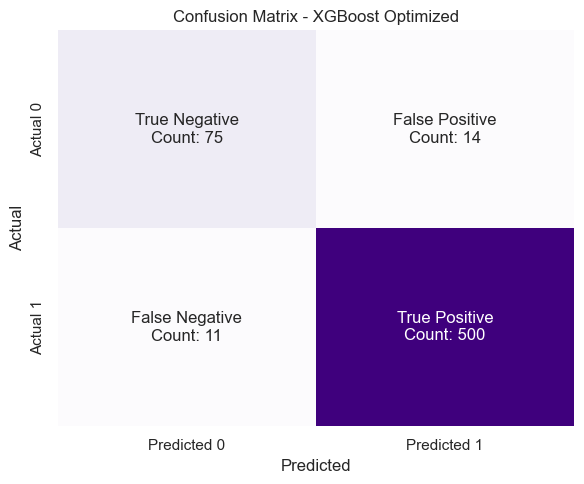

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions_xgb)
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
grouped_labels = [f"{label}\nCount: {value}" for label, value in zip(labels, cm.ravel())]
grouped_labels = np.asarray(grouped_labels).reshape(2, 2)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=grouped_labels, fmt='', cmap='Purples', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix - XGBoost Optimized')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

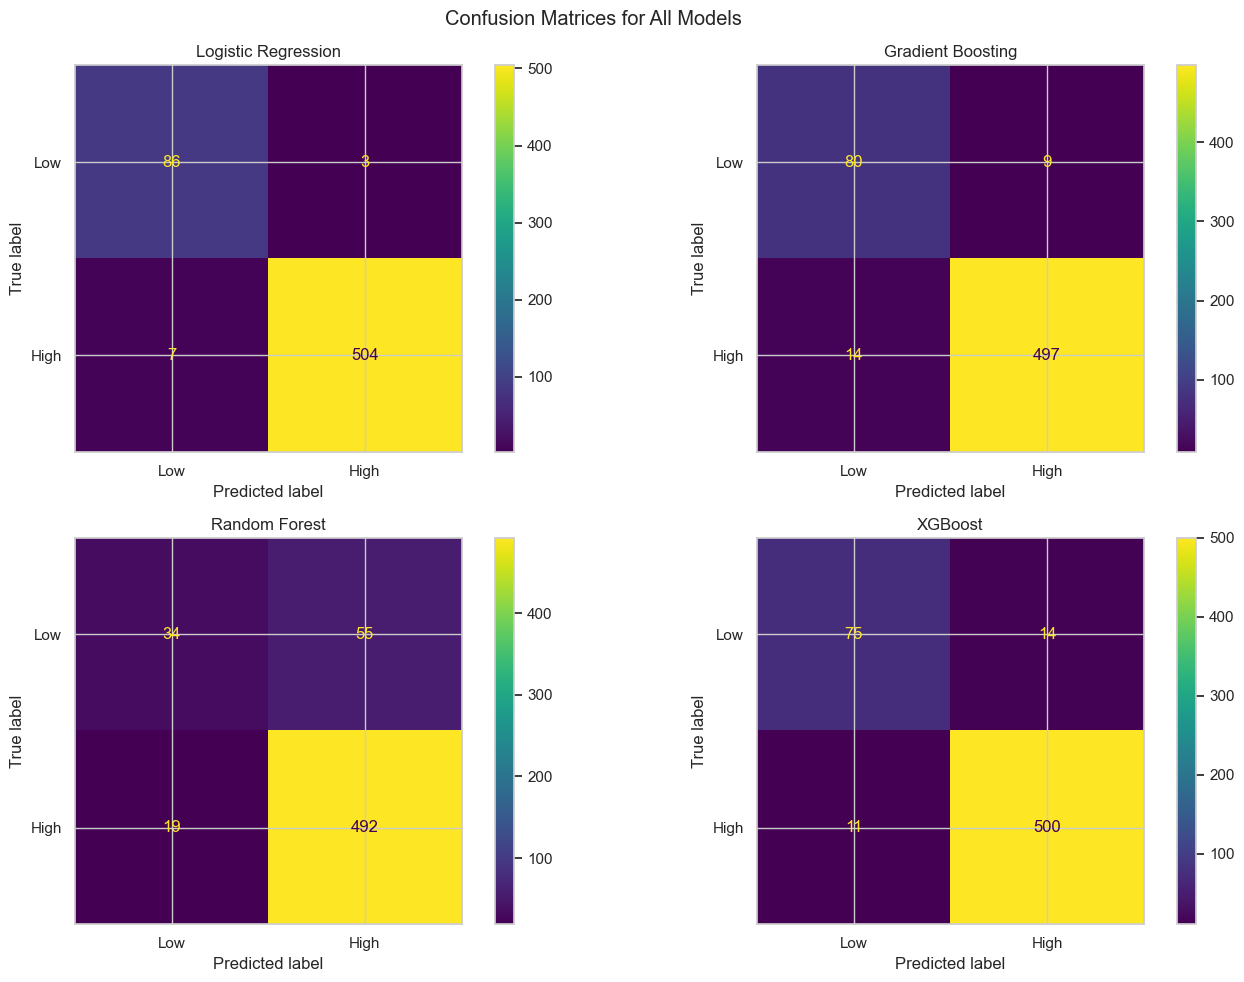

In [ ]:
# Confusion Matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]},
        n_iter=5, cv=3, random_state=42
    ),
    "XGBoost": RandomizedSearchCV(
        XGBClassifier(eval_metric='logloss', random_state=42),
        {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 8], 'learning_rate': [0.05, 0.1, 0.2]},
        n_iter=5, cv=3, random_state=42
    )
}

# Fit models and get predictions
model_preds = {}
model_probs = {}
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    model_preds[name] = preds
    model_probs[name] = probs

# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
for i, (name, preds) in enumerate(model_preds.items()):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
    disp.plot(ax=axes[i], values_format='d')
    axes[i].set_title(name)
plt.suptitle("Confusion Matrices for All Models")
plt.tight_layout()
plt.show()

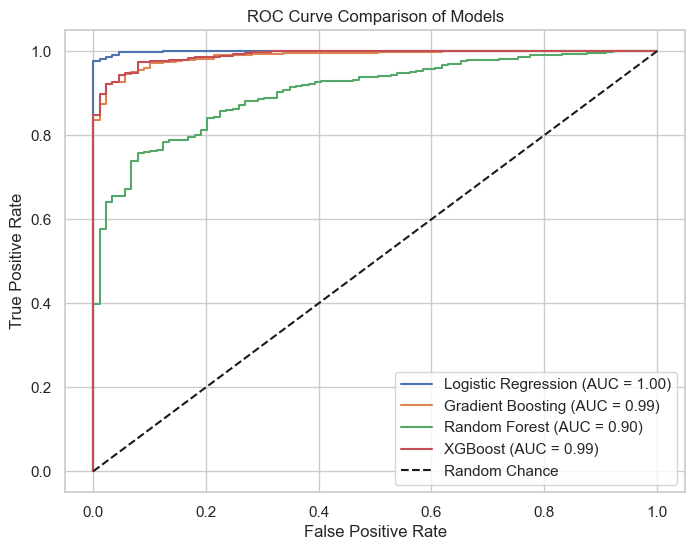

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# Logistic Regression
probs_log_reg = log_reg.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, probs_log_reg)
roc_auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")

# Gradient Boosting
probs_gboost = gboost.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, probs_gboost)
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {roc_auc_gb:.2f})")

# Random Forest Optimized
probs_rf = rf_optimized.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")

# XGBoost Optimized
probs_xgb = xgb_optimized.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, probs_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Unsupervised Learning (K-Means)

In [34]:
# Unsupervised Learning (K-Means):

high_risk_data = data[data['Addiction_Binary'] == 1].drop(["ID", "Name", "Addiction_Level", "Addiction_Binary"], axis=1)
high_risk_enc = pd.get_dummies(high_risk_data, drop_first=True)

pca = PCA(n_components=2)
dim_reduced_data = pca.fit_transform(high_risk_enc)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_predictions = kmeans.fit_predict(dim_reduced_data)

silhouette = silhouette_score(dim_reduced_data, kmeans_predictions)
print("Silhouette Score of K-Means Clustering: ", round(silhouette, 4))

# Here we begin with filtering for high risk individuals, these are the people with the binary value of 1. We then drop useless 
# columns, no identifiers, no original addiction ratings, no target column. One hot encoding is then applied to swap categorical 
# values to dummy variables 1's and 0's, which the model will understand better. The drop first avoids multicollinearity by dropping
# one column from each set of dummy variables. Then pca is used to reduce the feature space to 2 dimensions for vizualization and 
# efficiency. We then apply KMeans clustering on the dimensionally reduced data. 3 clusters are used and random_state = 42 allows for
# reproducibility. Then the silhouette score is calculated to evalute the clustering quality and outputted. 

Silhouette Score of K-Means Clustering:  0.4239



Cluster Counts:
0    770
1    885
2    899
Name: count, dtype: int64


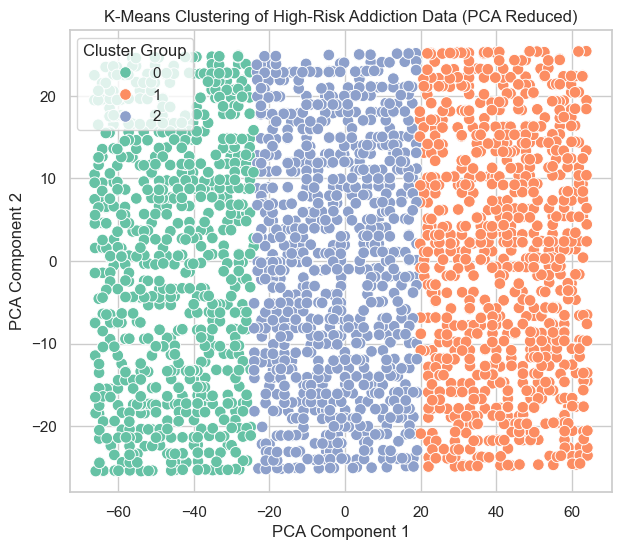

In [35]:
#cluster counts summary table (since all are high risk, no binary label here)
cluster_counts = pd.Series(kmeans_predictions).value_counts().sort_index()
print("\nCluster Counts:")
print(cluster_counts)

# Scatter plot of clusters
plt.figure(figsize=(7, 6))
sns.scatterplot(x=dim_reduced_data[:, 0], y=dim_reduced_data[:, 1], hue=kmeans_predictions, palette="Set2", s=70)
plt.title("K-Means Clustering of High-Risk Addiction Data (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster Group")
plt.grid(True)
plt.show()

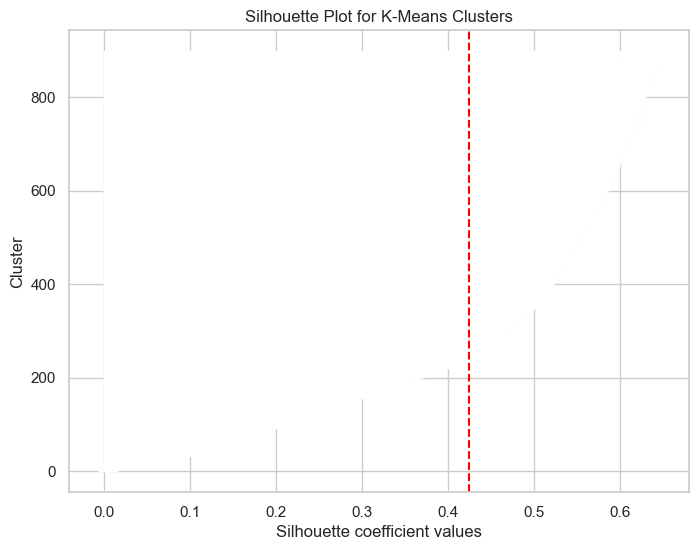

In [38]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import numpy as np

silhouette_vals = silhouette_samples(dim_reduced_data, kmeans_predictions)
y_ticks = []
plt.figure(figsize=(8,6))

for i, cluster in enumerate(np.unique(kmeans_predictions)):
    cluster_silhouette_vals = silhouette_vals[kmeans_predictions == cluster]
    cluster_silhouette_vals.sort()
    y_ticks.append(len(cluster_silhouette_vals)/2 + sum(y_ticks))
    plt.barh(range(len(cluster_silhouette_vals)), cluster_silhouette_vals, height=1.0)
    
# draw average silhouette score line    
plt.axvline(np.mean(silhouette_vals), color="red", linestyle="--")

plt.title("Silhouette Plot for K-Means Clusters")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster")
plt.show()

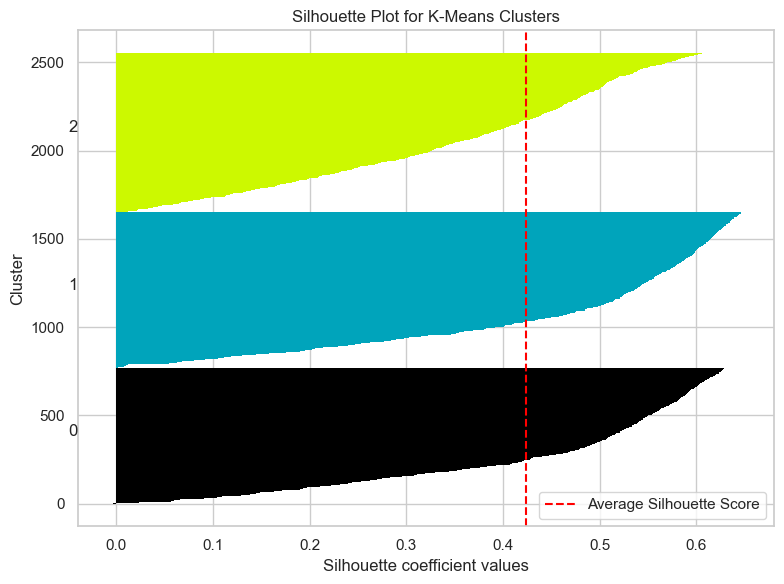

In [63]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

silhouette_vals = silhouette_samples(dim_reduced_data, kmeans_predictions)
y_lower = 0
plt.figure(figsize=(8, 6))

for i in range(3):  # Assuming 3 clusters
    cluster_silhouette_vals = silhouette_vals[kmeans_predictions == i]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0, color=color, edgecolor='none')
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper  # Move to the next cluster's bar

plt.axvline(np.mean(silhouette_vals), color="red", linestyle="--", label="Average Silhouette Score")
plt.title("Silhouette Plot for K-Means Clusters")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster")
plt.legend()
plt.tight_layout()
plt.show()